<a href="https://colab.research.google.com/github/boemer00/aot-object-tracking-aws/blob/working_model/working_model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!apt-get install awscli -y
!pip install --upgrade urllib3
!pip install --upgrade botocore
!pip install boto3


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  docutils-common fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript groff gsfonts
  imagemagick imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libimagequant0 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libnetpbm10 libraqm0 libwmflite-0.2-7 mailcap mime-support netpbm
  poppler-data psutils python3-botocore python3-certifi python3-chardet python3-colorama
  python3-dateutil python3-docutils python3-idna python3-jmespath python3-olefile python3-pil
  python3-pyasn1 python3-pygments python3-requests python3-roman python3-rsa python3-s3transfer
  python3-urllib3 python3-yaml sgml-base xml-core
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf f

In [2]:
# this section needs to be organised

import os
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import matplotlib.pyplot as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as F
import torchvision

# AWS S3

In [4]:
# initialise the S3 client
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# list the bucket contents
bucket_name = 'airborne-obj-detection-challenge-training'
result = s3_client.list_objects_v2(Bucket=bucket_name)

# print out the first 10 files
for i, content in enumerate(result.get('Contents', [])):
    if i >= 10:
        break
    print(content['Key'])


part1/ImageSets/groundtruth.csv
part1/ImageSets/groundtruth.json
part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv
part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.json
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773493822188340001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773494832603520001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773495887103050001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773497216090760001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773497811591170001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773499109254600001ba865c8e410e88609541b8f55ffc.png


In [5]:
# create a directory to dowmload images
os.makedirs('dataset', exist_ok=True)

bucket_name = 'airborne-obj-detection-challenge-training'
flight_id = '0001ba865c8e410e88609541b8f55ffc'
sequence_prefix = f'part1/Images/{flight_id}/'

# variables for pagination
image_count = 0
continuation_token = None

# loop to handle pagination
while True:
    if continuation_token:
        result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=sequence_prefix, ContinuationToken=continuation_token)
    else:
        result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=sequence_prefix)

    # check if any objects were found
    if 'Contents' in result:
        for content in result['Contents']:
            file_key = content['Key']

            # download only PNG files
            if file_key.endswith('.png'):
                local_filename = os.path.join('dataset', os.path.basename(file_key))
                s3_client.download_file(bucket_name, file_key, local_filename)
                image_count += 1

    # check if there are more objects to retrieve (pagination)
    if result.get('IsTruncated'):
        continuation_token = result['NextContinuationToken']
    else:
        break

print(f'Downloaded {image_count} images for flight ID {flight_id}.')

Downloaded 1199 images for flight ID 0001ba865c8e410e88609541b8f55ffc.


In [ ]:
import os

# Create a directory to download images
os.makedirs('dataset', exist_ok=True)

bucket_name = 'airborne-obj-detection-challenge-training'
flight_id = '0001ba865c8e410e88609541b8f55ffc'
sequence_prefix = f'part1/Images/{flight_id}/'

# Pagination variable
continuation_token = None
image_count = 0

# Loop to download PNG images while handling pagination
while True:
    result = s3_client.list_objects_v2(
        Bucket=bucket_name,
        Prefix=sequence_prefix,
        ContinuationToken=continuation_token
    )

    # Download each PNG file found
    for content in result.get('Contents', []):
        if content['Key'].endswith('.png'):
            s3_client.download_file(
                bucket_name,
                content['Key'],
                os.path.join('dataset', os.path.basename(content['Key']))
            )
            image_count += 1

    # Exit if there are no more pages
    continuation_token = result.get('NextContinuationToken')
    if not continuation_token:
        break

print(f'Downloaded {image_count} images for flight ID {flight_id}.')


# Checking the Images

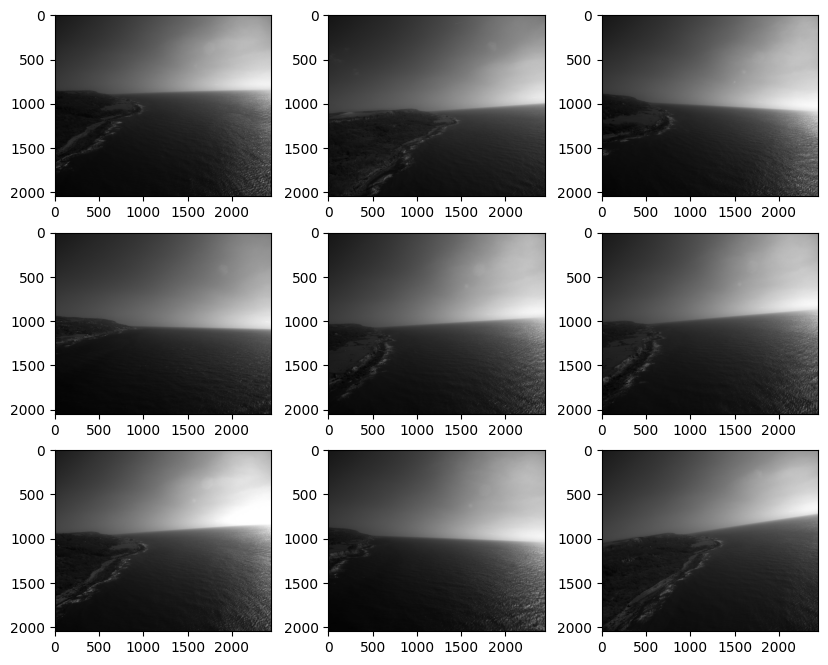

In [6]:
image_folder = 'dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

fig = plt.figure(figsize=(10,8))

for i in range(1, 10):
    img = cv2.imread(os.path.join(image_folder, image_files[i]))
    fig.add_subplot(3, 3, i)
    plt.imshow(img, cmap='gray')

plt.show()

# Annotations

In [7]:
os.makedirs('groundtruth', exist_ok=True)

csv_files = [
    'part1/ImageSets/groundtruth.csv',
    'part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv'
]

for file in csv_files:
    local_filename = os.path.join('groundtruth', os.path.basename(file))
    s3_client.download_file(bucket_name, file, local_filename)
    print(f"Downloaded {file} to {local_filename}")

print("All downloads completed.")

Downloaded part1/ImageSets/groundtruth.csv to groundtruth/groundtruth.csv
Downloaded part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv to groundtruth/valid_encounters_maxRange700_maxGap3_minEncLen30.csv
All downloads completed.


In [8]:
import pandas as pd

groundtruth_df = pd.read_csv('groundtruth/groundtruth.csv', index_col=0)
groundtruth_df.head(2)

,time,flight_id,img_name,frame,id,range_distance_m,is_above_horizon,size_width,size_height,gt_left,gt_top,gt_right,gt_bottom
0,1566556045879430639,673f29c3e4b4428fa26bc55d812d45d9,1566556045879430639673f29c3e4b4428fa26bc55d812...,3,NaN,NaN,NaN,2448,2048,NaN,NaN,NaN,NaN
1,1566556046008821070,673f29c3e4b4428fa26bc55d812d45d9,1566556046008821070673f29c3e4b4428fa26bc55d812...,4,NaN,NaN,NaN,2448,2048,NaN,NaN,NaN,NaN


In [11]:
# Check for any negative values in the bounding box columns
negative_values = groundtruth_df[['gt_left', 'gt_top', 'gt_right', 'gt_bottom']].lt(0).any().any()
if negative_values:
    print("There are negative values in the bounding box columns.")

# Check if gt_left < gt_right and gt_top < gt_bottom
invalid_bounding_boxes = (
    (groundtruth_df['gt_left'] >= groundtruth_df['gt_right']) |
    (groundtruth_df['gt_top'] >= groundtruth_df['gt_bottom'])
)

if invalid_bounding_boxes.any():
    print("There are improperly formatted bounding boxes.")
    # Display the problematic rows
    print(groundtruth_df[invalid_bounding_boxes])
else:
    print("All bounding boxes are properly formatted and non-negative.")



All bounding boxes are properly formatted and non-negative.


In [13]:
import pandas as pd
import numpy as np

def handle_empty_annotations(groundtruth_df):
    """
    Modify the DataFrame to handle cases where there are no annotations.
    Sets empty bounding boxes and labels for such cases.

    Parameters:
    - groundtruth_df: DataFrame containing bounding box annotations.

    Returns:
    - Updated DataFrame where entries with no annotations have empty values.
    """
    # Change the columns to dtype object to allow list assignment
    groundtruth_df = groundtruth_df.astype({
        'gt_left': 'object',
        'gt_top': 'object',
        'gt_right': 'object',
        'gt_bottom': 'object'
    })

    # Identify rows with missing bounding box annotations
    missing_annotations = groundtruth_df[['gt_left', 'gt_top', 'gt_right', 'gt_bottom']].isna().all(axis=1)

    # Set bounding boxes as empty lists for images with no annotations
    groundtruth_df.loc[missing_annotations, 'gt_left'] = [list()]*missing_annotations.sum()
    groundtruth_df.loc[missing_annotations, 'gt_top'] = [list()]*missing_annotations.sum()
    groundtruth_df.loc[missing_annotations, 'gt_right'] = [list()]*missing_annotations.sum()
    groundtruth_df.loc[missing_annotations, 'gt_bottom'] = [list()]*missing_annotations.sum()

    # Add a label to indicate no object present in the image, represented by an empty list
    groundtruth_df['labels'] = groundtruth_df.apply(
        lambda row: [] if missing_annotations[row.name] else [1], axis=1
    )

    return groundtruth_df

# Apply the function
groundtruth_df = handle_empty_annotations(groundtruth_df)
groundtruth_df.head()

,time,flight_id,img_name,frame,id,range_distance_m,is_above_horizon,size_width,size_height,gt_left,gt_top,gt_right,gt_bottom,labels
0,1566556045879430639,673f29c3e4b4428fa26bc55d812d45d9,1566556045879430639673f29c3e4b4428fa26bc55d812...,3,NaN,NaN,NaN,2448,2048,[],[],[],[],[1]
1,1566556046008821070,673f29c3e4b4428fa26bc55d812d45d9,1566556046008821070673f29c3e4b4428fa26bc55d812...,4,NaN,NaN,NaN,2448,2048,[],[],[],[],[1]
2,1566556046078455533,673f29c3e4b4428fa26bc55d812d45d9,1566556046078455533673f29c3e4b4428fa26bc55d812...,5,NaN,NaN,NaN,2448,2048,[],[],[],[],[1]
3,1566556046185850341,673f29c3e4b4428fa26bc55d812d45d9,1566556046185850341673f29c3e4b4428fa26bc55d812...,6,NaN,NaN,NaN,2448,2048,[],[],[],[],[1]
4,1566556046284871127,673f29c3e4b4428fa26bc55d812d45d9,1566556046284871127673f29c3e4b4428fa26bc55d812...,7,NaN,NaN,NaN,2448,2048,[],[],[],[],[1]


In [16]:
# Fill missing values in the 'id' column with 'no object'
groundtruth_df['id'] = groundtruth_df['id'].fillna('no_object')

# Fill missing values in the 'range_distance_m' column with -1 to indicate no object
groundtruth_df['range_distance_m'] = groundtruth_df['range_distance_m'].fillna(-1)

# Fill missing values in the 'is_above_horizon' column with 0 to indicate no object
groundtruth_df['is_above_horizon'] = groundtruth_df['is_above_horizon'].fillna(0)

In [19]:
# checking annotations for a single flight
flight_id_1 = '0001ba865c8e410e88609541b8f55ffc'

image_annotations = groundtruth_df[groundtruth_df['flight_id'] == flight_id_1]
image_annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 684441 to 685639
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              1199 non-null   int64  
 1   flight_id         1199 non-null   object 
 2   img_name          1199 non-null   object 
 3   frame             1199 non-null   int64  
 4   id                1199 non-null   object 
 5   range_distance_m  1199 non-null   float64
 6   is_above_horizon  1199 non-null   float64
 7   size_width        1199 non-null   int64  
 8   size_height       1199 non-null   int64  
 9   gt_left           1199 non-null   object 
 10  gt_top            1199 non-null   object 
 11  gt_right          1199 non-null   object 
 12  gt_bottom         1199 non-null   object 
 13  labels            1199 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 140.5+ KB


In [20]:
valid_encounters_df = pd.read_csv('groundtruth/valid_encounters_maxRange700_maxGap3_minEncLen30.csv', index_col=0)
valid_encounters_df = valid_encounters_df[valid_encounters_df['flight_id'] == flight_id_1]
valid_encounters_df

,encounter_id,flight_id,framemin,framemax,framecount,enc_len_with_gaps,is_above_horizon,min_enc_range,max_enc_range,median_enc_range,mean_enc_range
0,0.0,0001ba865c8e410e88609541b8f55ffc,229,325,97,97,-1.0,188.553218,698.099154,437.850254,439.41824


In [34]:
valid_encounters_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   encounter_id       1 non-null      float64
 1   flight_id          1 non-null      object 
 2   framemin           1 non-null      int64  
 3   framemax           1 non-null      int64  
 4   framecount         1 non-null      int64  
 5   enc_len_with_gaps  1 non-null      int64  
 6   is_above_horizon   1 non-null      float64
 7   min_enc_range      1 non-null      float64
 8   max_enc_range      1 non-null      float64
 9   median_enc_range   1 non-null      float64
 10  mean_enc_range     1 non-null      float64
dtypes: float64(6), int64(4), object(1)
memory usage: 96.0+ bytes


# Image Processing

In [21]:
import cv2

dataset_dir = 'dataset'
resized_dir = 'resized_dataset'

if not os.path.exists(resized_dir):
    os.makedirs(resized_dir, exist_ok=True)

output_size = (512, 512)

# list of images for a specific flight
flight_images = groundtruth_df[groundtruth_df['flight_id'] == flight_id_1]['img_name'].unique()

for image_file in flight_images:
    if image_file.endswith('.png'):
        # load
        image_path = os.path.join(dataset_dir, image_file)
        if not os.path.exists(image_path):
            print(f"Warning: Image not found: {image_path}")
            continue
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # resize
        resized_image = cv2.resize(image, output_size)

        # save
        output_path = os.path.join(resized_dir, image_file)
        cv2.imwrite(output_path, resized_image)

print(f'Resized {len(flight_images)} images for flight {flight_id_1}.')

Resized 1199 images for flight 0001ba865c8e410e88609541b8f55ffc.


# Model

Steps to implement Faster R-CNN:

*   Prepare the Dataset for Faster R-CNN
* Define the Faster R-CNN Model
* Train the Model
* Evaluate the Model
* Measure the Model’s Performance




## Prepare

In [25]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import cv2

class AirborneObjectDetection(Dataset):
    def __init__(self, img_dir, annotations_file, flight_id, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load and filter annotations for the given flight_id
        self.annotations = pd.read_csv(annotations_file)
        self.annotations = self.annotations[self.annotations['flight_id'] == flight_id]

        # Get all images in the directory
        self.all_images = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
      # Get image file name and path
      img_name = self.all_images[idx]
      img_path = os.path.join(self.img_dir, img_name)

      # Load the image in grayscale
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      if img is None:
          raise ValueError(f"Image {img_name} not found or unable to load.")

      # Convert the image to a tensor
      img = F.to_tensor(img)

      # Get annotations for the current image
      image_annotations = self.annotations[self.annotations['img_name'] == img_name]

      if not image_annotations.empty:
          # Extract bounding boxes
          boxes = image_annotations[['gt_left', 'gt_top', 'gt_right', 'gt_bottom']].values

          # Filter out any rows with NaN values in the bounding boxes
          valid_boxes = ~pd.isna(boxes).any(axis=1)
          boxes = boxes[valid_boxes]

          if len(boxes) > 0:
              # There are valid boxes, create labels
              labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming one class
              boxes = torch.as_tensor(boxes, dtype=torch.float32)
          else:
              # No valid boxes, treat as no objects
              boxes = torch.zeros((0, 4), dtype=torch.float32)
              labels = torch.zeros((0,), dtype=torch.int64)
      else:
          # Handle the case where there are no objects in the image
          boxes = torch.zeros((0, 4), dtype=torch.float32)
          labels = torch.zeros((0,), dtype=torch.int64)

      # Create the target dictionary
      target = {'boxes': boxes, 'labels': labels}

      # Apply transformations, if any
      if self.transform:
          img, target = self.transform(img, target)

      return img, target

In [26]:
# create the dataset
dataset = AirborneObjectDetection(
    img_dir='resized_dataset',
    annotations_file='groundtruth/groundtruth.csv',
    flight_id=flight_id_1
)

# fetch a sample
img, target = dataset[7]

print(f"Image shape: {img.shape}")
print(f"Target: {target}")

Image shape: torch.Size([1, 512, 512])
Target: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64)}


In [27]:
# split the dataset
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

## Train model

In [29]:
# create DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

# Replace the classifier head with a new one (for two classes: background and object)
num_classes = 2  # 1 class (object) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the appropriate device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 104MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [31]:
# set up the optimiser
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005
                            )

# set up the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1
                                               )

In [32]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        # Move images and targets to the correct device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Accumulate the loss for tracking
        total_loss += losses.item()

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: nan


KeyboardInterrupt: 

## Evaluate model

In [ ]:
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_predictions(images, outputs, threshold=0.5):
    """
    Visualizes the predictions on a batch of images.

    Parameters:
    - images: List of images in tensor format (C, H, W)
    - outputs: List of model outputs (predictions) containing 'boxes', 'labels', and 'scores'
    - threshold: Confidence score threshold for displaying predictions
    """
    for i, (image, output) in enumerate(zip(images, outputs)):
        # Convert the image to a numpy array
        image = F.to_pil_image(image)
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        ax = plt.gca()

        # Get the predicted boxes, labels, and scores
        boxes = output['boxes'].cpu().numpy()
        labels = output['labels'].cpu().numpy()
        scores = output['scores'].cpu().numpy()

        # Draw boxes and labels
        for box, label, score in zip(boxes, labels, scores):
            if score < threshold:
                continue  # Skip low-confidence predictions

            # Extract coordinates
            xmin, ymin, xmax, ymax = box

            # Draw the bounding box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)

            # Display the label and score
            text = f'Label: {label}, Score: {score:.2f}'
            ax.text(xmin, ymin - 5, text, fontsize=12, color='red',
                    bbox=dict(facecolor='yellow', alpha=0.5))

        plt.axis('off')
        plt.show()

# Evaluate the model and visualize predictions
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        # Visualize the first batch of images and predictions
        visualize_predictions(images, outputs, threshold=0.5)
        break  # Show only one batch for now


## Save model